In [8]:
# coding: utf-8

# In[1]:

import numpy as np
#import h5py
#import tensorflow as tf
#import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
#from scipy import signal
from tensorflow.python.keras.layers import Input,Conv2D,Concatenate,Flatten,Dense,LeakyReLU,Dropout, ReLU,Softmax
from tensorflow.python.keras.callbacks import TensorBoard,ModelCheckpoint
from tensorflow.python.keras.models import Model

from tensorflow.python.keras.losses import categorical_crossentropy
from tensorflow.python.keras import backend as K

from tensorflow.python.keras.activations import relu
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
fn = 2
d_min = 1
d_max = 10
blur_filter_size = 11
blur_range = 10
image_size = 256
epochs = 300
batch_size = 28

In [3]:
train_data_path = 'vcm_data/train_data_one_im_norm_2set_256_vcm_discrinimator.npy'
#test_data_path = 'test_data.npy'
train_label_path = 'vcm_data/train_label_one_im_norm_2set_256_vcm_discrinimator.npy'
#test_label_path = 'test_label.npy'

In [4]:
train_data = np.load(train_data_path)
#test_data = np.load(test_data_path)
train_label = np.load(train_label_path)

In [5]:
print(train_data.shape)
print(train_label.shape)

(40000, 256, 256, 1)
(40000, 3)


In [17]:
# In[7]:
input_image1 = Input(shape=(256,256,1), name = "input")
#layer1_1 = Conv2D(4, (8, 8), 8,padding='valid',activation=None,use_bias=False,kernel_initializer = my_init,trainable=True,name='layer1')(input_image1)
layer1_1 = Conv2D(1, (8, 8), 4,padding='valid',activation=relu, name="Conv1_1")(input_image1)

layer2_1 = Conv2D(1, (8, 8), 4,padding='valid',activation=relu, name="Conv2_1")(layer1_1)

flattened = Flatten(name="flat")(layer2_1)
dense1 = Dense(10, name="d1")(flattened)
ReLU1 = ReLU(name="lr1")(dense1)
Dp1 = Dropout(0.5)(ReLU1)

output_position = Dense(2, activation='softmax', name="out")(Dp1)

print(output_position)

model = Model(inputs=input_image1, outputs=output_position)
model.summary()


print(model.output_shape)

Tensor("out_2/Softmax:0", shape=(?, 2), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 256, 256, 1)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 63, 63, 1)         65        
_________________________________________________________________
Conv2_1 (Conv2D)             (None, 14, 14, 1)         65        
_________________________________________________________________
flat (Flatten)               (None, 196)               0         
_________________________________________________________________
d1 (Dense)                   (None, 10)                1970      
_________________________________________________________________
lr1 (ReLU)                   (None, 10)                0         
_________________________________________________________________
dropout_2 (Dropout)  

In [18]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001)
model.compile(loss='mse', optimizer=opt)

model.fit(train_data[:,:,:,:1], to_categorical(train_label[:, 2:]), epochs = epochs,batch_size = batch_size,verbose=1)

model.save('my_model_dis1.h5')

Epoch 1/20
40000/40000 [==============================] - 7s 167us/step - loss: 0.2457
Epoch 2/20
40000/40000 [==============================] - 6s 156us/step - loss: 0.2418
Epoch 3/20
40000/40000 [==============================] - 6s 157us/step - loss: 0.2389
Epoch 4/20
40000/40000 [==============================] - 6s 156us/step - loss: 0.2369
Epoch 5/20
40000/40000 [==============================] - 6s 157us/step - loss: 0.2350
Epoch 6/20
40000/40000 [==============================] - 6s 157us/step - loss: 0.2335
Epoch 7/20
40000/40000 [==============================] - 6s 157us/step - loss: 0.2324
Epoch 8/20
40000/40000 [==============================] - 6s 158us/step - loss: 0.2313
Epoch 9/20
40000/40000 [==============================] - 6s 158us/step - loss: 0.2306
Epoch 10/20
40000/40000 [==============================] - 6s 158us/step - loss: 0.2297
Epoch 11/20
40000/40000 [==============================] - 6s 158us/step - loss: 0.2294
Epoch 12/20
40000/40000 [================

In [19]:
# print(to_categorical(train_label[:10, 2:]))

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [20]:
# pred  = model.predict(train_data[:, :, :, :10])

[525. 525.   1.]
[0.29267606 0.70732397]


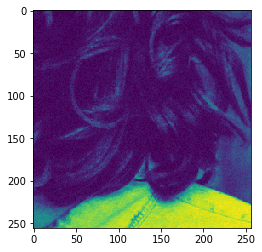

In [31]:
# idx = 2
# plt.imshow(train_data[idx, :, :, 0])

# print(train_label[idx, :])
# print(pred[idx, :])